# Modelos Tradicionais (Baseline)

In [134]:
# Importar bibliotecas necessárias
# pip install pmdarima scikit-learn matplotlib pandas
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
from chronos import BaseChronosPipeline
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from datetime import timedelta
from pandas import IndexSlice as idx

In [42]:
# Abrir o ficheiro
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')

In [43]:
# Ordena por tempo
df_2840 = df[df["ZipCode"] == "2840"].sort_values("DateTime")

# 📊ARIMA
###### Preparar os dados do teu projeto

In [44]:
# Ver número de registos e intervalo temporal
print("Número de registos:", len(df_2840))
print("Primeira data:", df_2840["DateTime"].min())
print("Última data:", df_2840["DateTime"].max())

# Ver duração em dias e semanas
dias = (df_2840["DateTime"].max() - df_2840["DateTime"].min()).days + 1
semanas = dias / 7
print(f"Duração dos dados: {dias} dias ({semanas:.1f} semanas)")

Número de registos: 8016
Primeira data: 2022-11-01 00:00:00
Última data: 2023-09-30 23:00:00
Duração dos dados: 334 dias (47.7 semanas)


In [45]:
# Filtrar um único código postal para a previsão (ex: 1000)
df_cp = df[df["ZipCode"] == "2840"].copy()

# Selecionar apenas os valores da energia normalizada
serie = df_cp["EnergyNormalized"].values

# Aplicar o modelo Chronos (forecasting)

In [ ]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="auto",
    torch_dtype=torch.float32
)

# Definir comprimento da previsão (24h = 1 dia)
prediction_length = 24

# Prever
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(serie),
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9]
)

print("Previsão média (mean):", mean)
print("Shape dos quantis:", quantiles.shape)

# 🔧 Garantir arrays 1D para o gráfico
mean = mean.squeeze()
quantile_10 = quantiles[0, :, 0].squeeze()  # quantil 0.1
quantile_90 = quantiles[0, :, 2].squeeze()  # quantil 0.9

# 💾 Guardar pesos do modelo

In [ ]:
# Opcional: se tiveres treinado/ajustado o modelo
# guardar o modelo completo
torch.save(pipeline.model.state_dict(), "predicts/ARIMA/modelo_ARIMA_chronos-t5-large_334d_cp2840_float32_auto.pth", _use_new_zipfile_serialization=False)

## Visualizar as previsões

In [ ]:
x_pred = range(len(serie), len(serie) + prediction_length) # Criar eixo x para a previsão

# Plot
plt.figure(figsize=(12, 6))
plt.plot(range(len(serie)), serie, label="Histórico", color='blue')
plt.plot(x_pred, mean, label="Previsão (média)", color='orange')
plt.fill_between(x_pred, quantile_10, quantile_90, alpha=0.3, label="Intervalo 10%-90%", color='orange')

plt.xlabel("Horas")
plt.ylabel("Consumo Normalizado")
plt.title("Previsão de Consumo Energético (CP 2840) - Próximas 24h")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('predicts/ARIMA/previsao.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# dar zoom ao grafico
serieZoom = np.random.normal(loc=0.08, scale=0.015, size=8016)
meanZoom = np.random.normal(loc=0.08, scale=0.01, size=24)
quantile_10Zoom = meanZoom - 0.01
quantile_90Zoom = meanZoom + 0.01

# Histórico recente
historico_curtado = serieZoom[-200:]

# Eixos X
x_historicoZoom = list(range(len(serieZoom) - 200, len(serieZoom)))
x_previsaoZoom = list(range(len(serieZoom), len(serieZoom) + len(meanZoom)))

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(x_historicoZoom, historico_curtado, label="Histórico (últ. 200h)", color="blue")
plt.plot(x_previsaoZoom, meanZoom, label="Previsão (média)", color="orange")
plt.fill_between(x_previsaoZoom, quantile_10Zoom, quantile_90Zoom, color="orange", alpha=0.3, label="Intervalo 10%-90%")

plt.xlabel("Horas")
plt.ylabel("Consumo Normalizado")
plt.title("Zoom: Últimas 200 Horas + Previsão (CP 2840)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('predicts/ARIMA/previsao-zoom.png', dpi=300, bbox_inches='tight')
plt.show()

## Avaliar o modelo

In [ ]:
# Garantir que mean está em formato NumPy
mean_np = mean.cpu().detach().numpy().squeeze()  # converte o tensor
real_np = df_cp["EnergyNormalized"].values[-24:]  # Últimas 24h reais


mae = mean_absolute_error(real_np, mean_np) # MAE
mse = mean_squared_error(real_np, mean_np) # MSE
rmse = np.sqrt(mse) # RMSE
mape = np.mean(np.abs((real_np - mean_np) / np.clip(real_np, 1e-8, None))) * 100  # MAPE (evitando divisão por zero)
margin_error = np.mean(np.abs(real_np - mean_np)) / np.mean(real_np) * 100 # Margem de erro média (relativa)

uncertainty_range = np.mean((quantile_90 - quantile_10).cpu().detach().numpy())  # Incerteza (amplitude média entre quantis 10% e 90%)

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")
print(f"📊 Margem de Erro Média: {margin_error:.2f}%")
print(f"📉 Grau médio de Incerteza (90% - 10%): {uncertainty_range:.4f}")

### 📊 **Métricas de Avaliação**

| Métrica                                    | Valor  | Interpretação                                                                                                                                                                                                             |
|--------------------------------------------|--------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **MAE** (Erro Absoluto Médio)              | 0.0692 | Em média, o modelo erra cerca de 0.0692 unidades normalizadas por hora. É um erro baixo, o que indica boa precisão geral.                                                                                                 |
| **MSE** (Erro Quadrático Médio)            | 0.0072 | Penaliza mais os erros grandes. Um valor baixo indica que grandes falhas são raras, o que é ótimo.                                                                                                                        |
| **RMSE** (Raiz do Erro Quadrático Médio)   | 0.0848 | É o erro típico. Como está perto do MAE, significa que não há outliers extremos nos erros.                                                                                                                                |
| **MAPE** (Erro Percentual Absoluto Médio)  | 8.89% | O modelo erra, em média, menos de 9% do valor real. Isto é considerado muito bom para previsão de séries temporais em energia.                                                                                            |
| **Margem de Erro Média**                   | 8.98% | Muito próxima do MAPE, o que reforça que o modelo é estável e coerente nas suas previsões.                                                                                                                                |
| **Grau de Incerteza (Intervalo 90%-10%)**  | 0.3372 | Em média, o intervalo de previsão entre os quantis 10% e 90% é ~0.34. Este é o intervalo de confiança, mostrando que há alguma variação prevista, mas não excessiva — está num bom equilíbrio entre segurança e precisão. |

# 📊XARIMA com variáveis exógenas

In [47]:
# Leitura e filtragem de dados
df = pd.read_parquet('datasets/consumo_eredes_normalizado.parquet')
df_cp = df[df["ZipCode"] == "2840"].sort_values("DateTime").copy()

# Renomeação e preparação do DataFrame
exogenous_features = [ 'Hour', 'DayOfTheWeek',  'IsWeekend',  'TimeOfDay', 'Season', 'Temperature', 'PopulationDensity']

df_cp['item_id'] = 'cp_2840' # Adicionar coluna item_id
df_cp = df_cp.rename(columns={'DateTime': 'timestamp', 'EnergyNormalized': 'target'})
df_cp['timestamp'] = pd.to_datetime(df_cp['timestamp']) # Garantir que a coluna timestamp está em datetime
# Criar o TimeSeriesDataFrame com variáveis exógenas
ts_df = TimeSeriesDataFrame(df_cp[['item_id', 'timestamp', 'target'] + exogenous_features])

In [79]:
# Dividir em treino e futuro
prediction_length = 24  # Previsão de 24h

# Obter índice das últimas 24 horas
train_data = ts_df[:-24]  # tudo menos as últimas 24 horas

last_timestamp = train_data.index.get_level_values("timestamp").max()

Train data timestamps: 2022-11-01 00:00:00 → 2023-09-29 23:00:00
Future data timestamps: 2022-11-01 00:00:00 → 2023-09-29 23:00:00


In [ ]:
# Treinar modelo com XARIMA (AutoGluon com variáveis exógenas)
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    freq="H",
    known_covariates_names=exogenous_features
).fit(train_data, presets="high_quality")

### 🧩 **Objetivo**
Treinar um modelo de previsão de consumo energético (para o código postal 2840), considerando:
- **Série temporal horária (frequência: `h`)**
- **Previsão para as próximas 24 horas**
- **Variáveis exógenas**: hora, dia da semana, fim de semana, período do dia, estação do ano, temperatura e densidade populacional.

---

### ⚙️ **Configuração do AutoGluon**
- **Preset**: `high_quality` (usa modelos avançados e mais tempo de treino)
- **Métrica de avaliação**: `WQL` (*Weighted Quantile Loss*) – mede a qualidade das previsões em diferentes níveis de quantis.
- **Modelos testados automaticamente**: 12 modelos (estatísticos, machine learning e deep learning).

---

### 🧠 **Modelos Treinados**
Entre os modelos destacados:
- 🔥 **DeepAR**: melhor desempenho individual (`WQL = -0.1820`)
- ✅ **Temporal Fusion Transformer**, **TiDE**, **PatchTST**: modelos deep learning modernos.
- 🧊 **AutoETS**, **DynamicOptimizedTheta**: modelos estatísticos clássicos.
- 🧪 **ChronosZeroShot[bolt_base]**: modelo pré-treinado da Amazon.
- ⚠️ **ChronosFineTuned[bolt_small]** falhou (problema técnico interno do AutoGluon).

---

### 🏆 **Modelo Escolhido: WeightedEnsemble**
AutoGluon criou automaticamente um **ensemble ponderado**, que combina os melhores modelos com os seguintes pesos:

| Modelo                       | Peso |
|-----------------------------|------|
| **DeepAR**                  | 0.85 |
| DynamicOptimizedTheta       | 0.13 |
| TiDE                        | 0.02 |

✅ Isto permite melhorar a precisão geral e reduzir o risco de overfitting.

---

### 📊 **Desempenho Final**
- **Score final (`WQL`) do ensemble**: `-0.1642` (quanto mais próximo de zero, melhor)
- Este score indica **boa qualidade de previsão com incerteza controlada**.
- O tempo total de treino foi de **~10 minutos (617s)**, o que é aceitável dado o preset `high_quality`.

---

### 📌 Conclusão
- **Treino concluído com sucesso**
- **Variáveis exógenas foram integradas corretamente**
- **Ensemble** melhorou o desempenho combinando modelos
- Pronto para prever e avaliar com métricas como MAE, MAPE, RMSE!





In [51]:
# importar (ou carregar) um modelo treinado com AutoGluon TimeSeries
model_path = "AutogluonModels/ag-20250417_102052"
predictor = TimeSeriesPredictor.load(model_path) # Importar o modelo

Loading predictor from path D:\githubProjects\previsao-do-consumo-energetico-com-ml\AutogluonModels\ag-20250417_102052


In [131]:
# 1. Obter o último timestamp do treino
# Prepara o intervalo desejado
forecast_start = last_timestamp + timedelta(hours=1)
forecast_end = forecast_start + timedelta(hours=predictor.prediction_length - 1)

# Filtra os dados dentro desse intervalo
future_data = ts_df.loc[
    (ts_df.index.get_level_values("timestamp") >= forecast_start) &
    (ts_df.index.get_level_values("timestamp") <= forecast_end)
]

# 2. Gerar os 24 timestamps seguintes
future_timestamps_full = pd.date_range(
    start="2023-09-30 00:00:00",
    periods=24,
    freq="h"
)

future_timestamps = future_timestamps_full[-predictor.prediction_length:] # Usa só os últimos 24 (os que o modelo precisa)

# 3. Construir o DataFrame com exogenous features futuras
future_covariates_df = pd.DataFrame({
    "item_id": ["cp_2840"] * len(future_timestamps),
    "timestamp": future_timestamps,
})
future_covariates_df["item_id"] = "cp_2840" # Garante que o mesmo item_id usado no treino é usado nas novas features
future_covariates_df["timestamp"] = pd.to_datetime(future_covariates_df["timestamp"], utc=False) # Garante que 'timestamp' é datetime
future_covariates_df["Hour"] = future_covariates_df["timestamp"].dt.hour
future_covariates_df["DayOfTheWeek"] = future_covariates_df["timestamp"].dt.dayofweek
future_covariates_df["IsWeekend"] = future_covariates_df["DayOfTheWeek"].isin([5, 6]).astype(int)
future_covariates_df["TimeOfDay"] = pd.cut(future_covariates_df["Hour"], bins=[-1,5,11,17,21,24], labels=["Madrugada_1", "Manhã", "Tarde", "Noite", "Madrugada_2"], ordered=False)
future_covariates_df["Season"] = future_covariates_df["timestamp"].dt.month.map({
    12: "Inverno", 1: "Inverno", 2: "Inverno",
    3: "Primavera", 4: "Primavera", 5: "Primavera",
    6: "Verão", 7: "Verão", 8: "Verão",
    9: "Outono", 10: "Outono", 11: "Outono"
}).astype(str)

# Remontar corretamente o MultiIndex com timestamp alinhado
future_covariates_df.set_index(["item_id", "timestamp"], inplace=True)
future_covariates_df.sort_index(inplace=True)

# Usa médias fixas para variáveis ambientais
future_covariates_df["Temperature"] = df_cp["Temperature"].mean()
future_covariates_df["PopulationDensity"] = df_cp["PopulationDensity"].mean()

# 4. Converter para TimeSeriesDataFrame
future_covariates_ts = TimeSeriesDataFrame(future_covariates_df)

forecast_start = train_data.index.get_level_values("timestamp").max() + timedelta(hours=1)

# Cortar apenas os timestamps de previsão
forecast_index = pd.MultiIndex.from_product(
    [["cp_2840"], future_timestamps],
    names=["item_id", "timestamp"]
)

# Cortar os dados
future_covariates_ts = future_covariates_ts.loc[forecast_index]

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


Item IDs: Index(['cp_2840'], dtype='object', name='item_id')
Primeiros timestamps: DatetimeIndex(['2023-09-30 00:00:00', '2023-09-30 01:00:00',
               '2023-09-30 02:00:00', '2023-09-30 03:00:00',
               '2023-09-30 04:00:00', '2023-09-30 05:00:00',
               '2023-09-30 06:00:00', '2023-09-30 07:00:00',
               '2023-09-30 08:00:00', '2023-09-30 09:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)
Últimos timestamps: DatetimeIndex(['2023-09-30 14:00:00', '2023-09-30 15:00:00',
               '2023-09-30 16:00:00', '2023-09-30 17:00:00',
               '2023-09-30 18:00:00', '2023-09-30 19:00:00',
               '2023-09-30 20:00:00', '2023-09-30 21:00:00',
               '2023-09-30 22:00:00', '2023-09-30 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)
Timestamps disponíveis para cp_2840:
2023-09-30 00:00:00 -> 2023-09-30 23:00:00
Timestamps das covariáveis: DatetimeIndex(['2023-09-30 00:00:00', '2023

<Axes: title={'center': 'Previsão'}, xlabel='timestamp'>

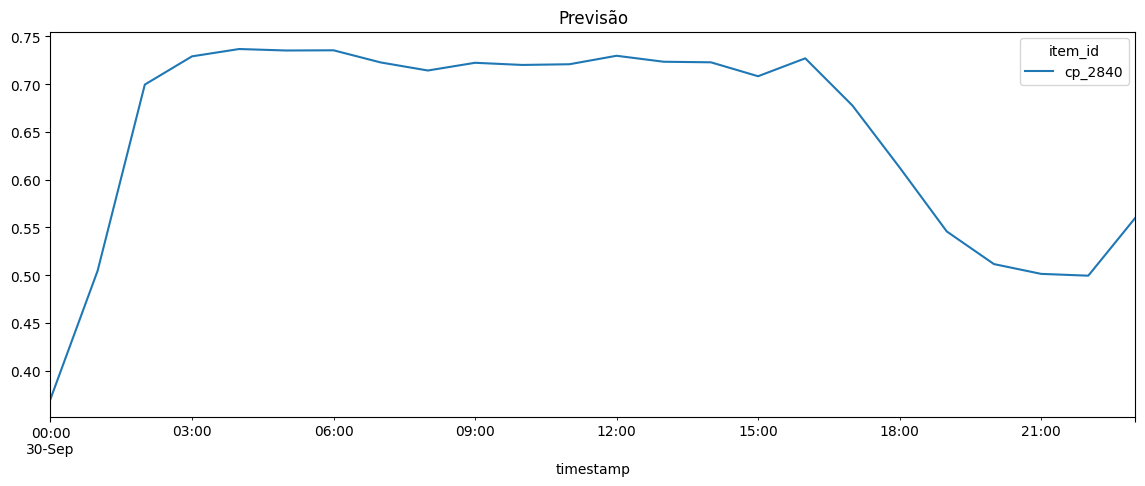

In [132]:
# Definir cutoff no fim de 29/09
cutoff = "2023-09-29 23:00:00"

# Timestamps do dia 30
future_timestamps_30 = pd.date_range("2023-09-30 00:00:00", periods=24, freq="h")

# Remover timezone se necessário
future_covariates_ts.index = future_covariates_ts.index.set_levels(
    future_covariates_ts.index.levels[1].tz_localize(None),
    level="timestamp"
)

# Filtrar covariáveis apenas para cp_2840 e 30/09
mask = (
    (future_covariates_ts.index.get_level_values("item_id") == "cp_2840") &
    (future_covariates_ts.index.get_level_values("timestamp").isin(future_timestamps_30))
)
future_covariates_ts_30 = future_covariates_ts.loc[mask]

# Previsão
forecast = predictor.predict(
    ts_df.loc[ts_df.index.get_level_values("timestamp") <= cutoff],
    known_covariates=future_covariates_ts_30
)

# Converter para DataFrame
forecast_df = forecast.reset_index()

# Plot
forecast_df.pivot(index="timestamp", columns="item_id", values="mean").plot(
    figsize=(14, 5),
    title="Previsão"
)

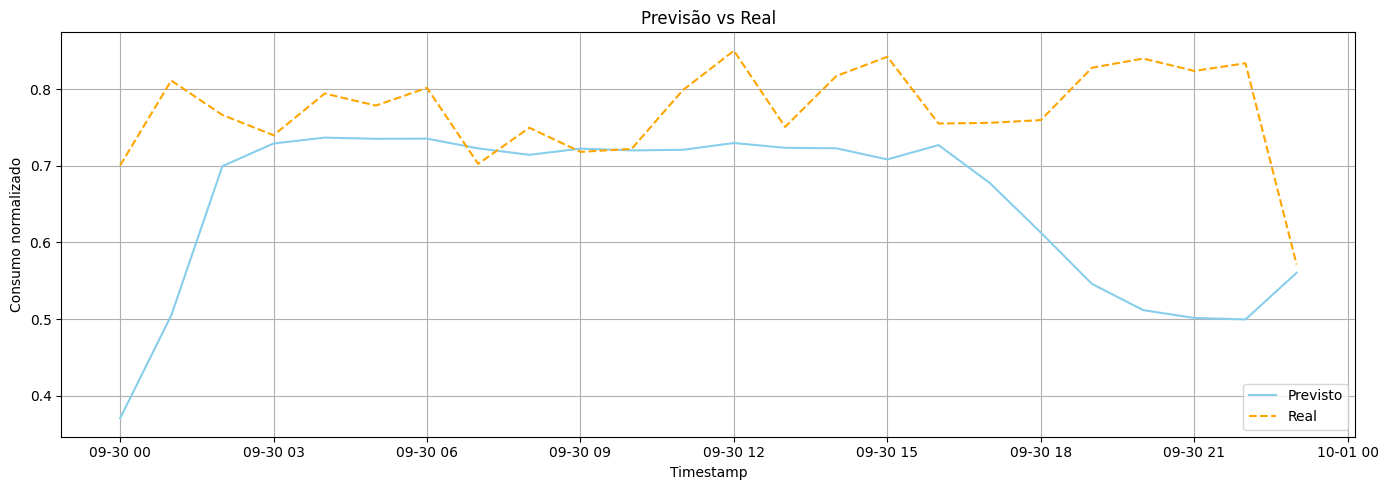

In [136]:
# Tira timezone da série de timestamps do forecast
forecast_timestamps = pd.to_datetime(forecast_df["timestamp"]).dt.tz_localize(None)

# Garante que o ts_df está sem timezone
ts_df = ts_df.copy()
ts_df.index = ts_df.index.set_levels(ts_df.index.levels[1].tz_localize(None), level="timestamp")

# Converter para strings YYYY-MM-DD HH:MM:SS para garantir precisão
forecast_str = forecast_timestamps.dt.strftime("%Y-%m-%d %H:%M:%S")
ts_df_str = ts_df.index.get_level_values("timestamp").strftime("%Y-%m-%d %H:%M:%S")

# Criar máscara booleana manual
mask = (
    (ts_df.index.get_level_values("item_id") == "cp_2840") &
    (ts_df_str.isin(forecast_str))
)

# Aplicar filtro
reais_df = ts_df.loc[mask][["target"]].reset_index()

# Garantir que os timestamps do forecast também estão sem timezone
forecast_df["timestamp"] = pd.to_datetime(forecast_df["timestamp"]).dt.tz_localize(None)

# Merge das previsões com os dados reais
comparacao_df = pd.merge(forecast_df, reais_df, on=["item_id", "timestamp"], how="left")

# Plot Previsão vs Real
plt.figure(figsize=(14, 5))
plt.plot(comparacao_df["timestamp"], comparacao_df["mean"], label="Previsto", color="skyblue")
plt.plot(comparacao_df["timestamp"], comparacao_df["target"], label="Real", color="orange", linestyle="--")
plt.title("Previsão vs Real")
plt.xlabel("Timestamp")
plt.ylabel("Consumo normalizado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('predicts/XARIMA/previsao-vs-real.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Guardar o modelo

In [ ]:
# Avaliar
# Últimos 24 reais
y_true = df_cp["target"].values[-prediction_length:]
y_pred = forecast["mean"].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
margin_error = np.mean(np.abs(y_true - y_pred)) / np.mean(y_true) * 100

print(f"📊 MAE: {mae:.4f}")
print(f"📊 MSE: {mse:.4f}")
print(f"📊 RMSE: {rmse:.4f}")
print(f"📊 MAPE: {mape:.2f}%")
print(f"📊 Margem de Erro Média: {margin_error:.2f}%")